In [42]:
import numpy as np
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# setup for problem
# get the setup for the problem
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, super2choi
from opentn.optimization import compose_superops_list, frobenius_norm
d, N, gamma = 2, 4, 1
tau = 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma)
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

# 2 site superoperator ansatz
from opentn.transformations import lindbladian2super, create_supertensored_from_local
superop_nn = lindbladian2super(Li=[Lnn])
exp_nn_odd = exp_operator_dt(superop_nn, tau=tau/2, backend='jax')
exp_nn_even = exp_operator_dt(superop_nn, tau=tau, backend='jax')

print(np.linalg.matrix_rank(super2choi(exp_Lvec)))
print(frobenius_norm(compose_superops_list([exp_Lvec_odd, exp_Lvec_even, exp_Lvec_odd]), exp_Lvec))

55
0.0959176702323516


In [88]:
# how would we vectorize the identity?
from opentn.transformations import vectorize_dissipative, vectorize_hamiltonian, dissipative2liouvillian_full
Inn = np.eye(d**2)
print(np.allclose(vectorize_dissipative(Inn), np.zeros((d**4,d**4))), np.allclose(vectorize_hamiltonian(Inn), np.zeros((d**4,d**4))))
# as wrote out on paper, the identity "vectorized" is just zero
print(dissipative2liouvillian_full(L=Lnn, i=1, N=N, num_sites=2).shape)

True True
(256, 256)


In [89]:
from opentn.transformations import convert_supertensored2liouvillianfull
# corresponds to site order: (N-1, 0), (1, 2)
even_full_test = create_supertensored_from_local(exp_nn_even, N=N, pbc=False, layer=1)
swaped_test = convert_supertensored2liouvillianfull(even_full_test, N, d, shift_pbc=True)
np.allclose(swaped_test, exp_Lvec_even)

True

In [90]:
# now another question I have is even the components I am using would make isometries. CHECK
from opentn.transformations import factorize_psd_truncated, choi2ortho
from opentn.stiefel import is_isometry_2
print(is_isometry_2(choi2ortho(factorize_psd_truncated(super2choi(exp_nn_even.real), chi_max=2))))
print(is_isometry_2(choi2ortho(factorize_psd_truncated(super2choi(np.eye(d**4,d**4)), chi_max=d**4))))

test_odd = create_supertensored_from_local(exp_nn_odd, N)
test_odd = convert_supertensored2liouvillianfull(test_odd, N, d)
print(np.allclose(test_odd@swaped_test@test_odd, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd)) # AMAZING
print(frobenius_norm(test_odd@swaped_test@test_odd, exp_Lvec))

True
True
True
0.09591767023235137


# Next steps:
(18 OCT 2023)

1. I want the above functions to be a comprehensible framework. What does this mean?
    a. Their should be one "factory" that takes superop_local -> super_full_liouvillian that takes as argument the parity and shifts (PBC) for the even layer.
    b. I need to try this out fully when also changing the exp(L_full) to include the PBC for the term [N-1,0].
    c. Include a special case for the non PBC such that this old comparison still works
    c. Add even layer to unit tests 
2. Try optimization with the PBC case for St(N)
3. EXTRA: finish creation of identity maps!

In [92]:
# trying out again things but with pbc=True!
from opentn.transformations import create_trotter_layers

d, N, gamma = 2, 4, 1
tau = 4

Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma, pbc=True)
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers(liouvillians=[Lvec, Lvec_odd, Lvec_even], tau=tau)

print(frobenius_norm(compose_superops_list([exp_Lvec_odd, exp_Lvec_even, exp_Lvec_odd]), exp_Lvec))

superop_nn = lindbladian2super(Li=[Lnn])

exp_nn_odd = exp_operator_dt(superop_nn, tau=tau/2, backend='jax')
exp_nn_even = exp_operator_dt(superop_nn, tau=tau, backend='jax')

test_even_pbc = create_supertensored_from_local(exp_nn_even, N, pbc=True, layer=1)
test_even_pbc = convert_supertensored2liouvillianfull(test_even_pbc, N, d, shift_pbc=True)

test_odd = create_supertensored_from_local(exp_nn_odd, N)
test_odd = convert_supertensored2liouvillianfull(test_odd, N, d)

0.14312675894435653


In [94]:
# these is supposed to fail 
print(np.allclose(create_supertensored_from_local(exp_nn_even, N, layer=1), create_supertensored_from_local(exp_nn_even, N, pbc=True, layer=1)))
# these are supposed to pass
print(np.allclose(test_odd@test_even_pbc@test_odd, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd)) # AMAZING
print(np.allclose(Lvec, Lvec_odd+Lvec_even))

np.linalg.matrix_rank(super2choi(exp_Lvec)), 4**3, 2**4 # NOTE: the 2 comes from the fact that 2 kraus operators come out from the liouvillian acting on 2 sites.

False
True
True


(45, 64, 16)

In [84]:
# I want to create a utility function that converts the superoperator to orthogonal directly
from opentn.transformations import super2ortho
from opentn.stiefel import check_isometries
from opentn.optimization import model_stiefel_local
xs_pbc_stiefel = [super2ortho(x.real) for x in [exp_nn_odd, exp_nn_even, exp_nn_odd]] # all have (8,4) = (4*2,4) = (out*rank, in)
print(check_isometries(xs_pbc_stiefel), [op.shape for op in xs_pbc_stiefel]) 
print(frobenius_norm(model_stiefel_local(xs_pbc_stiefel, N=N, d=d), exp_Lvec))

[True, True, True] [(8, 4), (8, 4), (8, 4)]
0.14312675894435722


In [15]:
# now it is time to define the elements for the optimization!
from opentn.stiefel import retract_stiefel, gradient_stiefel_vec, riemannian_hessian_vec
f_stiefel = lambda xi: frobenius_norm(model_stiefel_local(xi, N=N, d=d), exp_Lvec)
grad_stiefel = lambda xi: gradient_stiefel_vec(xi, f_stiefel)
hessian_stiefel = lambda xi: riemannian_hessian_vec(xi, f_stiefel)

In [19]:
from opentn.trust_region_rcopt import riemannian_trust_region_optimize
xs_pbc_1, f_pbc_1, err_pbc_1, radius_pbc_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_pbc_stiefel, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
radius 0.0025
iteration: 4
column : 0
column : 1
column : 2
radius 0.000625
iteration: 5
column : 0
column : 1
column : 2
radius 0.000625
iteration: 6
column : 0
column : 1
column : 2
radius 0.00125
iteration: 7
column : 0
column : 1
column : 2
radius 0.0025
iteration: 8
column : 0
column : 1
column : 2
radius 0.005
iteration: 9
column : 0
column : 1
column : 2
radius 0.00125
iteration: 10
column : 0
column : 1
column : 2
radius 0.00125
iteration: 11
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 12
column : 0
column : 1
column : 2
radius 0.000625
iteration: 13
column : 0
column : 1
column : 2
radius 0.000625
iteration: 14
column : 0
column : 1
column : 2
radius 0.000625
iteration: 15
column : 0
column : 1
column : 2
radius 0.000625
iteration: 16
colum

In [20]:
xs_pbc_2, f_pbc_2, err_pbc_2, radius_pbc_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_pbc_1, niter=20, radius_init=radius_pbc_1
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 1
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 2
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 3
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 4
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 5
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 6
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 7
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 8
column : 0
column : 1
column : 2
radius 0.000625
iteration: 9
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 10
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 11
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 12
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 13
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 14
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 15
column : 0
column :

0.8853557271233199 [True, True, True]


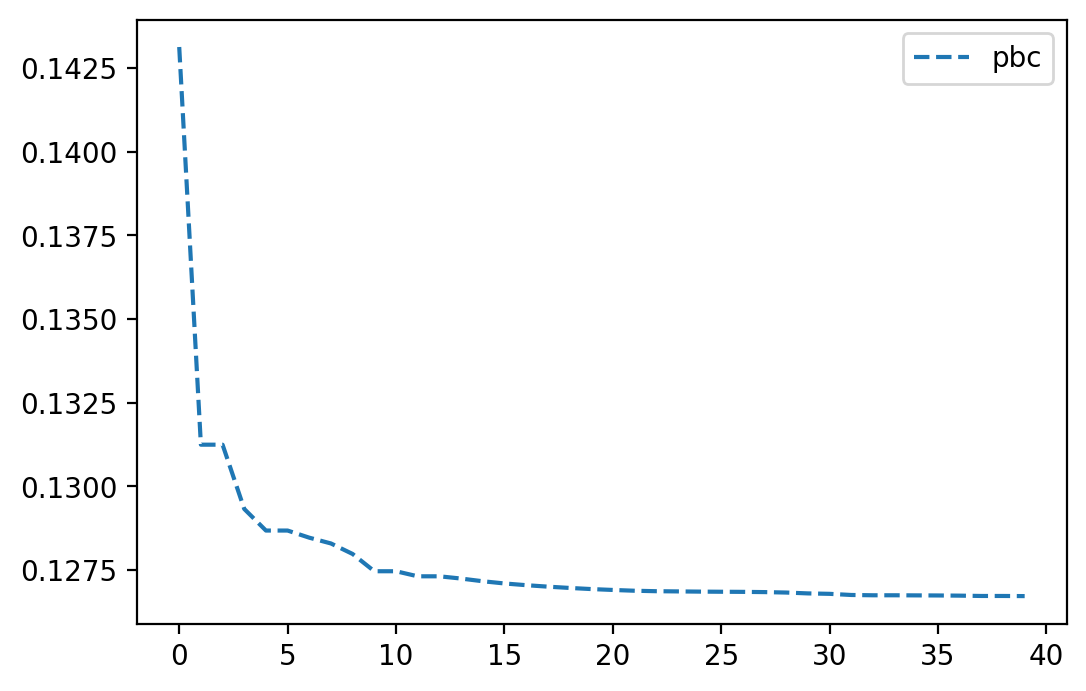

In [95]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.plot(f_pbc_1 + f_pbc_2, '--', label='pbc')
plt.legend()
print(f_pbc_2[-1]/f_pbc_1[0], check_isometries(xs_pbc_2))

In [71]:
# just to be sure that everything is right: TODO: I need to check that the error of this model decreases with tau**3
taus = np.logspace(start=2, stop=-9, num=12, base=2)[::-1]
error_fro = []
for tau in taus:
    exp_tot_tau = exp_operator_dt(Lvec, tau=tau, backend='jax')
    exp_odd_tau = exp_operator_dt(Lvec_odd, tau=tau/2, backend='jax')
    exp_even_tau = exp_operator_dt(Lvec_even, tau=tau, backend='jax')
    error_fro.append(frobenius_norm(exp_odd_tau@exp_even_tau@exp_odd_tau,exp_tot_tau))

[1.953125e-03 3.906250e-03 7.812500e-03 1.562500e-02 3.125000e-02
 6.250000e-02 1.250000e-01 2.500000e-01 5.000000e-01 1.000000e+00
 2.000000e+00 4.000000e+00]


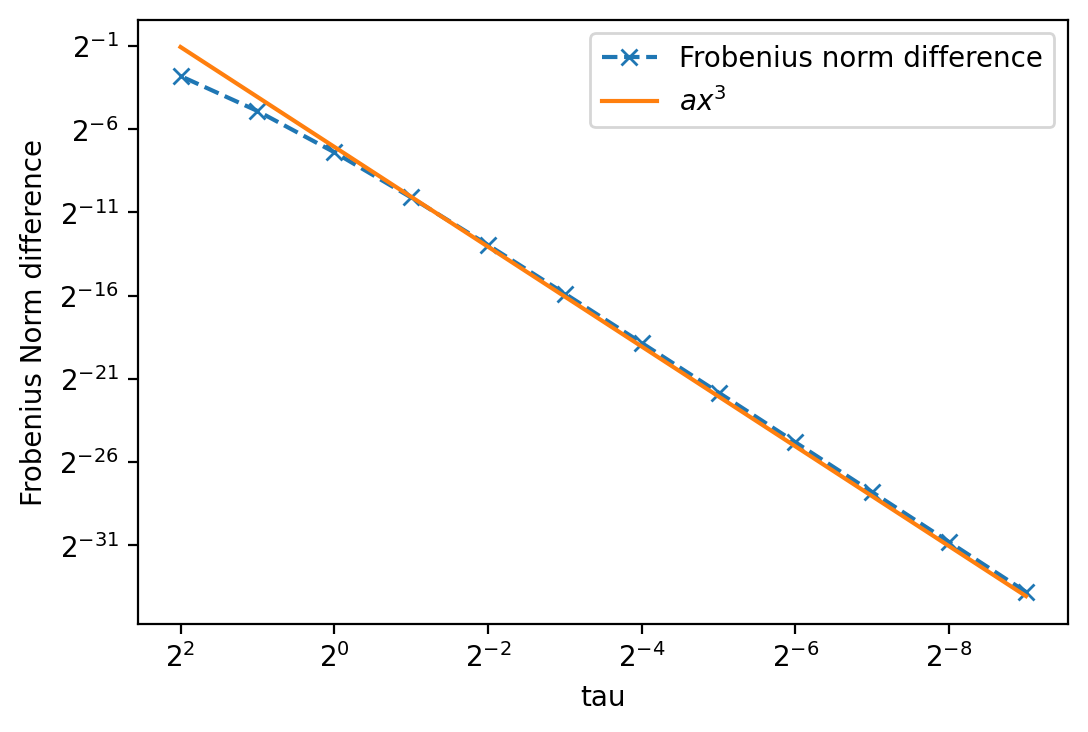

In [72]:
a = 0.0075
fig = plt.figure(dpi=200)
plt.loglog(taus, error_fro, '--x', base=2, label='Frobenius norm difference')
plt.plot(taus, a*taus**3, label=r'$a x^3$')
plt.gca().invert_xaxis()
plt.ylabel(r'Frobenius Norm difference')
plt.xlabel('tau')
plt.legend()
print(taus)

In [354]:
# after checking that this works as it is supposed to (based on error behaviour and unittests)
# so the next thing is to try canonical metric!
# 1. Start with the gradients
from opentn.stiefel import gradient_ambient2riemannian, gradient_stiefel, gradient_canonical
gradients_ambient = jax.grad(f_stiefel)(xs_pbc_stiefel)
gradients_euclidean = [gradient_ambient2riemannian(x,z) for x,z in zip(xs_pbc_stiefel, gradients_ambient)]
print([np.allclose(g1, g2) for g1, g2 in zip(gradients_euclidean,  gradient_stiefel(xs_pbc_stiefel, f_stiefel))])

gradients_canonical = [gradient_ambient2riemannian(x,z, 1, 1/2) for x,z in zip(xs_pbc_stiefel, gradients_ambient)]
print([np.allclose(g1, g2) for g1, g2 in zip(gradients_canonical, gradient_canonical(xs_pbc_stiefel, f_stiefel))])

[True, True, True]
[True, True, True]


In [359]:
from opentn.stiefel import gradient_stiefel_general
# TODO: make a unittest of this
print([np.allclose(g1, g2) for g1, g2 in zip(gradient_stiefel_general(xs_pbc_stiefel, f_stiefel, alpha0=1, alpha1=1),  gradient_stiefel(xs_pbc_stiefel, f_stiefel))])
print([np.allclose(g1, g2) for g1, g2 in zip(gradient_stiefel_general(xs_pbc_stiefel, f_stiefel, alpha0=1, alpha1=1/2), gradient_canonical(xs_pbc_stiefel, f_stiefel))])

[True, True, True]
[True, True, True]


In [172]:
# now, there seems to be an issue with the riemannian connection.
from opentn.stiefel import project, get_unit_matrices, is_in_tangent_space
# let me calculate D_eta(nu):
grad_func = lambda xi: gradient_stiefel(xi, f_stiefel)
x = xs_pbc_stiefel
unit_matrices = get_unit_matrices(x)
k = 1
grads = grad_func(x)
_, jvp_eval = jax.jvp(grad_func, (x,), ([jnp.zeros_like(op, dtype=np.float64) if l!=i else project(X=op, Z=jnp.roll(unit_matrices[l],k)) for l,op in enumerate(x)],))
[np.allclose(op, np.zeros_like(op)) for op in jvp_eval]

[False, False, False]

In [173]:
[is_in_tangent_space(x, grad) for x,grad in zip(x, jvp_eval)]

[True, True, True]

In [174]:
[np.allclose(project(x, grad), grad) for x,grad in zip(x, jvp_eval)]

[True, True, True]

In [185]:
from opentn.stiefel import riemannian_connection
hessian_metric = riemannian_connection(D_nu=jvp_eval[k], nu=grads[k], eta=project(X=x[k], Z=unit_matrices[k]), x=x[k], alpha0=1, alpha1=1/2)
print(np.allclose(hessian_metric, np.zeros_like(hessian_metric)))
print(np.allclose(hessian_metric, jvp_eval[k]))
print(np.allclose(project(x[k], jvp_eval[k]), jvp_eval[k]))

False
True
True


In [182]:
nu=grads[k]
# eta=project(X=x[k], Z=unit_matrices[k])
eta = project(x[k], unit_matrices[k])         
print(np.allclose((eta.T @ nu + nu.T @ eta), np.zeros_like(eta.T @ nu + nu.T @ eta)))
print(np.allclose((eta @ nu.T + nu @ eta.T), np.zeros_like(eta @ nu.T + nu @ eta.T)))

# This sort of gives me the idea that the hessian would not change. What could be wrong is me assuming that I should
# project the Ei and that is why the whole thing is in the tangent space by default.

True
True


In [678]:
# lets try to quickly run an optimization with the canonical gradient instead
grad_stiefel_canon = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='canonical')

# I F*CKED up here, the original (see plot) was ran using Px not the current implementation
# xs_pbc_canon_1, f_pbc_canon_1, err_pbc_canon_1, radius_pbc_canon_1 = riemannian_trust_region_optimize(
#     f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel, xs_pbc_stiefel, niter=20
# )

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.02
iteration: 4
column : 0
column : 1
column : 2
radius 0.005
iteration: 5
column : 0
column : 1
column : 2
radius 0.01
iteration: 6
column : 0
column : 1
column : 2
radius 0.0025
iteration: 7
column : 0
column : 1
column : 2
radius 0.0025
iteration: 8
column : 0
column : 1
column : 2
radius 0.000625
iteration: 9
column : 0
column : 1
column : 2
radius 0.000625
iteration: 10
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 11
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 12
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 13
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 14
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 15
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 16

In [180]:
xs_pbc_canon_2, f_pbc_canon_2, err_pbc_canon_2, radius_pbc_canon_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel, xs_pbc_canon_1, niter=20, radius_init=radius_pbc_2
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 1
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 2
column : 0
column : 1
column : 2
radius 0.000625
iteration: 3
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 4
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 5
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 6
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 7
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 8
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 9
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 10
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 11
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 12
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 13
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 14
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 15
column : 0
column : 1
c

In [385]:
grad_stiefel_euclidean = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='euclidean')
hessian_stiefel_euclidean = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='euclidean')


xs_pbc_euclidean_1, f_pbc_euclidean_1, err_pbc_euclidean_1, radius_pbc_euclidean_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_euclidean, hessian_stiefel_euclidean, xs_pbc_stiefel, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.02
iteration: 4
column : 0
column : 1
column : 2
radius 0.005
iteration: 5
column : 0
column : 1
column : 2
radius 0.00125
iteration: 6
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 7
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 8
column : 0
column : 1
column : 2
radius 1.953125e-05
iteration: 9
column : 0
column : 1
column : 2
radius 4.8828125e-06
iteration: 10
column : 0
column : 1
column : 2
radius 1.220703125e-06
iteration: 11
column : 0
column : 1
column : 2
radius 3.0517578125e-07
iteration: 12
column : 0
column : 1
column : 2
radius 7.62939453125e-08
iteration: 13
column : 0
column : 1
column : 2
radius 1.9073486328125e-08
iteration: 14
column : 0
column : 1
column : 2
radius 4.76837158203125e-09
iteration: 15
column : 0
c

In [680]:
hessian_stiefel_canon = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='canonical')
xs_pbc_canon_upd_1, f_pbc_canon_upd_1, err_pbc_canon_upd_1, radius_pbc_canon_upd_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel_canon, xs_pbc_stiefel, niter=20
)
# NOTE: attempt without the projection gave worst results

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.02
iteration: 4
column : 0
column : 1
column : 2
radius 0.02
iteration: 5
column : 0
column : 1
column : 2
radius 0.005
iteration: 6
column : 0
column : 1
column : 2
radius 0.00125
iteration: 7
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 8
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 9
column : 0
column : 1
column : 2
radius 1.953125e-05
iteration: 10
column : 0
column : 1
column : 2
radius 4.8828125e-06
iteration: 11
column : 0
column : 1
column : 2
radius 1.220703125e-06
iteration: 12
column : 0
column : 1
column : 2
radius 3.0517578125e-07
iteration: 13
column : 0
column : 1
column : 2
radius 7.62939453125e-08
iteration: 14
column : 0
column : 1
column : 2
radius 1.9073486328125e-08
iteration: 15
column : 0
column : 1
column

In [380]:
xs_pbc_canon_upd_2, f_pbc_canon_upd_2, err_pbc_canon_upd_2, radius_pbc_canon_upd_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel_canon, xs_pbc_canon_upd_1, niter=20, radius_init=radius_pbc_canon_upd_1
)

iteration: 0
column : 0
column : 1
column : 2
radius 4.656612873077393e-12
iteration: 1
column : 0
column : 1
column : 2
radius 1.1641532182693482e-12
iteration: 2
column : 0
column : 1
column : 2
radius 2.9103830456733704e-13
iteration: 3
column : 0
column : 1
column : 2
radius 7.275957614183426e-14
iteration: 4
column : 0
column : 1
column : 2
radius 1.4551915228366852e-13
iteration: 5
column : 0
column : 1
column : 2
radius 3.637978807091713e-14
iteration: 6
column : 0
column : 1
column : 2
radius 9.094947017729283e-15
iteration: 7
column : 0
column : 1
column : 2
radius 2.2737367544323206e-15
iteration: 8
column : 0
column : 1
column : 2
radius 5.684341886080802e-16
iteration: 9
column : 0
column : 1
column : 2
radius 1.4210854715202004e-16
iteration: 10
column : 0
column : 1
column : 2
radius 3.552713678800501e-17
iteration: 11
column : 0
column : 1
column : 2
radius 8.881784197001253e-18
iteration: 12
column : 0
column : 1
column : 2
radius 2.220446049250313e-18
iteration: 13
col

In [438]:
from opentn.transformations import ortho2choi
np.linalg.matrix_rank(ortho2choi(xs_pbc_stiefel[0])), np.linalg.matrix_rank(ortho2choi(xs_pbc_canon_upd_2[0]))

(2, 2)

In [441]:
print(xs_pbc_stiefel[0])
print(xs_pbc_canon_upd_2[0])
check_isometries(xs_pbc_canon_upd_2)

[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.16214860e-16 -8.70513862e-17  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -8.89400392e-01 -1.10599608e-01  0.00000000e+00]
 [ 0.00000000e+00  3.13635673e-01 -3.13635673e-01  0.00000000e+00]
 [ 0.00000000e+00 -1.10599608e-01 -8.89400392e-01  0.00000000e+00]
 [ 0.00000000e+00  3.13635673e-01 -3.13635673e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.85302597e-17]]
[[-1.00000000e+00 -1.99926276e-12  1.73728669e-12  5.12690018e-14]
 [ 4.35837690e-13 -3.08642001e-14 -3.46389584e-14  3.73980013e-17]
 [ 1.31575975e-12 -8.86707371e-01 -1.13246904e-01 -8.11547878e-13]
 [-1.50425679e-12  3.21703741e-01 -3.12140804e-01 -6.49702514e-13]
 [-1.05381932e-12 -1.13246904e-01 -8.86707371e-01  1.10161880e-12]
 [-1.49927734e-12  3.12140804e-01 -3.21703741e-01 -6.43832210e-13]
 [-5.12690018e-14  1.84997850e-13 -4.74897899e-13 -1.00000000

[True, True, True]

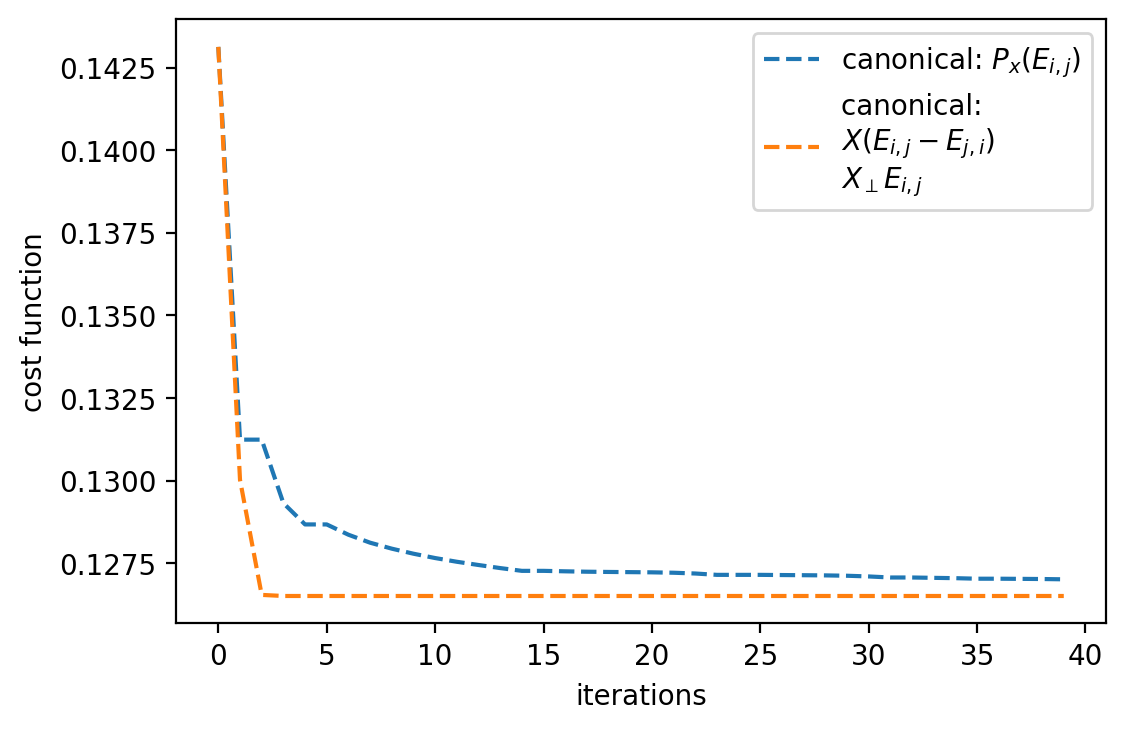

In [409]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.ylabel('cost function')
plt.xlabel('iterations')
# plt.plot(f_pbc_1 + f_pbc_2, '--', label='euclidean')
# plt.plot(f_pbc_euclidean_1, '--', label='euclidean (grad and hess) (metric)')
plt.plot(f_pbc_canon_1 + f_pbc_canon_2, '--', label=r'canonical: $P_x(E_{i,j})$')
plt.plot(f_pbc_canon_upd_1 + f_pbc_canon_upd_2, '--', label='canonical: \n' + r'$X(E_{i,j} - E_{j,i})$' + '\n' + r'$X_\perp E_{i,j} $')
plt.legend()

In [389]:
f_pbc_euclidean_1[-1], f_pbc_canon_upd_1[-1]

(DeviceArray(0.12651185, dtype=float64),
 DeviceArray(0.12651185, dtype=float64))

# Checking the coordinates vector field

In [383]:
from opentn.stiefel import get_elementary_tangent_direction, get_k_unit_matrix
x = xs_pbc_stiefel[0]
p = x.shape[1]
k = 1
Eij = get_k_unit_matrix(dim0=p, dim1=p, k=k)
print(Eij - Eij.T)
print(get_elementary_tangent_direction(k,x))


[[ 0.  1.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.00000000e+00 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.70513862e-17 -2.16214860e-16  0.00000000e+00  0.00000000e+00]
 [ 8.89400392e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.13635673e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.10599608e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.13635673e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


### Note:

As expected from the theory, if i = j, we have the whole antisymmetric matrix to be zero. 

Is this a mere consequence of the number of real parameters that parametrize the tangent spaces of the stiefel manifold? 

the antisymmetric component only has p(p-1)/2 free parameters for real matrices (p^2 for complex matrices) while there are p^2 total parameters (2*p^2 for complex matrices)

So does this mean that the k for antisymmetric elementary tangent directions would only have to traverse the upper diagonal?

> I think it should be fine as long as we are consistently "over paramtrizing" everywhere, meaning in the gradient, hessian, and retraction! (???) 

## What happens for other values of (i,j)

In [341]:
Eij = get_k_unit_matrix(dim0=p, dim1=p, k=1)
Eji = get_k_unit_matrix(dim0=p, dim1=p, k=4)

print(Eij - Eij.T)
print(Eji - Eji.T)

[[ 0.  1.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0. -1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [342]:
from opentn.stiefel import canonical_metric
delta1 = x @ (Eij - Eij.T)
delta2 = x @ (Eji - Eji.T)
canonical_metric(delta1, delta2, x)
# -1 is the result, which shows that they are the negative of each other, and therefore not orthogonal

-0.9999999999999999

In [442]:
# would the elements in the upper diagonal be orthogonal?
# 1: (0,1)
# 6: (1,2)
print(canonical_metric(get_elementary_tangent_direction(1,x), get_elementary_tangent_direction(6,x), x)) # so yes, basically orthogonal
print(canonical_metric(get_elementary_tangent_direction(1,x), get_elementary_tangent_direction(5,x), x)) # this is also zero, but for the wrong reasons?
# the element at the main diagonal for real values is all zero, so is this really something meaningful??


-1.0263416486754031e-48
0.0



Similarly, we see that the element (i,j) and (j,i) are not linearly independent, as these are the negative of each other. So the only linearly independent are the UPPER DIAGONAL! This correspondents to the idea of unit vector being orthogonal to each other, and therefore spanning the whole space! So this means, that we only need the UPPER DIAGONAL to span the antisymmetric part of the tangent space!!!

In [343]:
from rqcopt.util import real_to_antisymm
print(real_to_antisymm(Eji)), print(real_to_antisymm(Eij)) # only for squared matrices!

canonical_metric(x@real_to_antisymm(Eji), x@real_to_antisymm(Eij), x)

[[ 0. +0.j  -0.5+0.5j  0. +0.j   0. +0.j ]
 [ 0.5+0.5j  0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]]
[[ 0. +0.j   0.5+0.5j  0. +0.j   0. +0.j ]
 [-0.5+0.5j  0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]]


0.0

this does not look like "just" the negative of the Eij one tho! This is confirmed by the inner product being zero, which means that they are orthogonal!! (which does not happen for the real case). NOTE, however, that this is because we are trying to span the complex antisymmetric space. So in theory all the p^2 elements should count. If this is true, this should also be the case for the main diagonal terms, lets try:

In [348]:
E00 = get_k_unit_matrix(dim0=p, dim1=p, k=0)
print(real_to_antisymm(E00))
canonical_metric(x@real_to_antisymm(E00), x@real_to_antisymm(Eij), x)
# it is numerically zero, as expected.

[[0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


-2.8224395338573586e-48

# Next: increase rank with non zero elements??

## rank 4

In [443]:
from opentn.transformations import super2choi
np.linalg.matrix_rank(super2choi(exp_nn_odd)), np.linalg.svd(super2choi(exp_nn_odd), compute_uv=False)

(2,
 array([3.60653066e+00, 3.93469340e-01, 1.44707238e-16, 5.22606002e-17,
        3.33041711e-17, 1.67385555e-17, 7.66005602e-18, 4.38715177e-18,
        1.09656020e-32, 4.48415516e-34, 5.48225984e-50, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))

In [454]:
xs_stiefel_rank4 = [super2ortho(x.real, rank=4) for x in [exp_nn_odd, exp_nn_even, exp_nn_odd]]
print([op.shape for op in xs_stiefel_rank4])
print(f_stiefel(xs_stiefel_rank4))

[(16, 4), (16, 4), (16, 4)]
0.14312675894435714


In [549]:
# optimization with twice the rank as before to see if we can achieve a better result
xs_canon_rank4_1, f_canon_rank4_1, err_canon_rank4_1, radius_canon_rank4_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel_canon, xs_stiefel_rank4, save_x=True, niter=40
)

# we see from this that it actually improves, but not that much, it also shows a fast saturation after the 10th iteration.
# what we can try however, is to keep increasing the rank and if not to fill those zeros with "small numbers."

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.04
iteration: 4
column : 0
column : 1
column : 2
radius 0.01
iteration: 5
column : 0
column : 1
column : 2
radius 0.02
iteration: 6
column : 0
column : 1
column : 2
radius 0.04
iteration: 7
column : 0
column : 1
column : 2
radius 0.01
iteration: 8
column : 0
column : 1
column : 2
radius 0.02
iteration: 9
column : 0
column : 1
column : 2
radius 0.04
iteration: 10
column : 0
column : 1
column : 2
radius 0.04
iteration: 11
column : 0
column : 1
column : 2
radius 0.04
iteration: 12
column : 0
column : 1
column : 2
radius 0.01
iteration: 13
column : 0
column : 1
column : 2
radius 0.02
iteration: 14
column : 0
column : 1
column : 2
radius 0.02
iteration: 15
column : 0
column : 1
column : 2
radius 0.02
iteration: 16
column : 0
column : 1
column : 2
radius 0.005
iterat

## rank 8

In [456]:
xs_stiefel_rank8 = [super2ortho(x.real, rank=8, eps=1e-50) for x in [exp_nn_odd, exp_nn_even, exp_nn_odd]]
print([op.shape for op in xs_stiefel_rank8])
print(f_stiefel(xs_stiefel_rank8))

[(32, 4), (32, 4), (32, 4)]
0.14312675894435717


In [460]:
xs_canon_rank8_1, f_canon_rank8_1, err_canon_rank8_1, radius_canon_rank8_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel_canon, xs_stiefel_rank8, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.04
iteration: 4
column : 0
column : 1
column : 2
radius 0.01
iteration: 5
column : 0
column : 1
column : 2
radius 0.02
iteration: 6
column : 0
column : 1
column : 2
radius 0.02
iteration: 7
column : 0
column : 1
column : 2
radius 0.04
iteration: 8
column : 0
column : 1
column : 2
radius 0.01
iteration: 9
column : 0
column : 1
column : 2
radius 0.02
iteration: 10
column : 0
column : 1
column : 2
radius 0.02
iteration: 11
column : 0
column : 1
column : 2
radius 0.04
iteration: 12
column : 0
column : 1
column : 2
radius 0.01
iteration: 13
column : 0
column : 1
column : 2
radius 0.02
iteration: 14
column : 0
column : 1
column : 2
radius 0.005
iteration: 15
column : 0
column : 1
column : 2
radius 0.01
iteration: 16
column : 0
column : 1
column : 2
radius 0.02
iterat

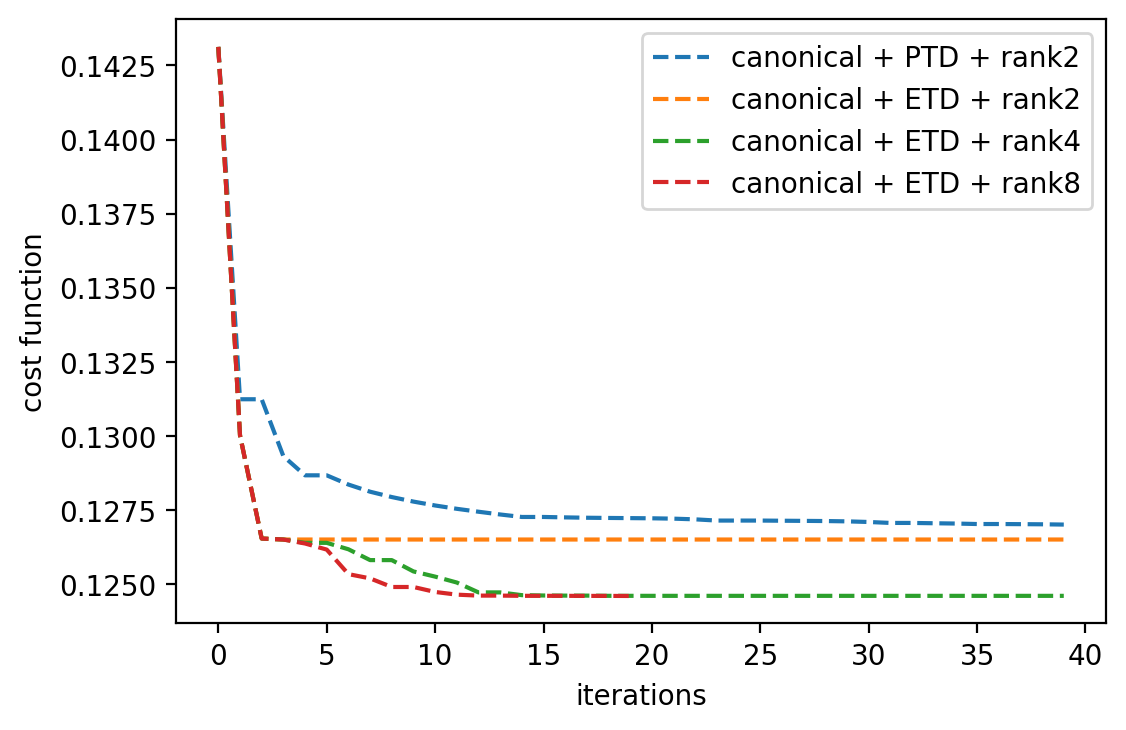

In [550]:
plt.figure(dpi=200)
plt.ylabel('cost function')
plt.xlabel('iterations')
plt.plot(f_pbc_canon_1 + f_pbc_canon_2, '--', label='canonical + PTD + rank2')
plt.plot(f_pbc_canon_upd_1 + f_pbc_canon_upd_2, '--', label='canonical + ETD + rank2')
plt.plot(f_canon_rank4_1, '--', label='canonical + ETD + rank4')
plt.plot(f_canon_rank8_1, '--', label='canonical + ETD + rank8')
plt.legend()

## NOTE:
increasing the rank does improve the optimization, but not as much as one would expect. Eventho the rank 8 decreases faster, it ends up in the same position as the rank 4 at iteration 20.

## NEXT:
let's see again what are the rank of the full thing, the odd, even layer, and see what kind of elements are in the spaces we "add" when increasing the rank, and what is the general trend (whether they increase, how much, are the x's getting significantly farther from the original ansatz? Constantly?)

In [465]:
[np.linalg.matrix_rank(super2choi(op)) for op in [exp_Lvec, exp_Lvec_odd, exp_Lvec_even]]
# this is really interesting. The odd and even layer rank matches what we expect
# but the full one has a lower rank than in the full-layer nopbc. Does this make sense?

[45, 4, 4]

In [470]:
exp_Lvec.shape, np.linalg.svd(super2choi(exp_Lvec),compute_uv=False)[:48]

((256, 256),
 array([8.06965294e+00, 1.97212888e+00, 1.62365416e+00, 1.62365416e+00,
        6.22680898e-01, 4.61525866e-01, 2.82932950e-01, 2.37880446e-01,
        1.60479645e-01, 1.60479645e-01, 1.46943462e-01, 1.09316489e-01,
        9.45388657e-02, 9.45388657e-02, 5.09576643e-02, 3.55505995e-02,
        3.47648401e-02, 3.33687580e-02, 3.33687580e-02, 2.25329114e-02,
        2.25329114e-02, 1.58359837e-02, 1.58359837e-02, 1.52212026e-02,
        1.31542701e-02, 7.10473720e-03, 6.41803007e-03, 5.88867647e-03,
        2.72449770e-03, 2.72449770e-03, 2.37015931e-03, 2.37015931e-03,
        2.26224513e-03, 1.95115184e-03, 1.89145766e-03, 1.67185792e-03,
        1.67185792e-03, 1.45312873e-03, 1.12308860e-03, 1.08955498e-03,
        1.01331907e-03, 7.89787715e-04, 7.89787715e-04, 5.80422127e-04,
        5.80422127e-04, 3.56954953e-15, 1.19137712e-15, 9.93966135e-16]))

In [482]:
# I re-ran the optimization with the updated trust region method so we can access to all the x's. Let's see
np.allclose(xs_canon_rank4_1[0][0], xs_stiefel_rank4[0])

True

In [497]:
# 1. how does the elements that are added when increasing the rank to 4 look like:
from opentn.transformations import find_nonzero
([ortho2choi(op) for op in xs_pbc_stiefel][0]) # each of them as shape (16,2) = (in*out, rank)

array([[-1.00000000e+00, -2.16214860e-16],
       [ 0.00000000e+00, -8.70513862e-17],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [-8.89400392e-01,  3.13635673e-01],
       [-1.10599608e-01, -3.13635673e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [-1.10599608e-01,  3.13635673e-01],
       [-8.89400392e-01, -3.13635673e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00,  4.85302597e-17]])

In [535]:
print([ortho2choi(op) for op in xs_stiefel_rank4][2])
# some of teh values are really small (e-23) but others are (only one) in 1e-8 order.

[[-1.00000000e+00 -2.16214860e-16 -1.01383636e-08 -3.84255121e-09]
 [ 0.00000000e+00 -8.70513862e-17  7.81419281e-10  6.57852571e-10]
 [ 0.00000000e+00  0.00000000e+00 -1.35558665e-23  4.72807967e-24]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.99077039e-24]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.89400392e-01  3.13635673e-01  6.57490500e-09 -2.23779759e-09]
 [-1.10599608e-01 -3.13635673e-01  1.03807694e-09 -1.81869313e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.10599608e-01  3.13635673e-01  1.01244101e-09 -9.48477032e-10]
 [-8.89400392e-01 -3.13635673e-01  6.54926907e-09 -1.36758150e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e

In [503]:
print(ortho2choi(xs_canon_rank4_1[-1][0]))

[[-9.99989437e-01  7.18349736e-04  3.95470993e-03 -2.13339849e-03]
 [ 4.75133004e-06 -1.90232008e-04 -2.64374015e-05  6.40985081e-06]
 [ 5.61937369e-04  1.97977563e-04 -2.08502141e-06  4.07291877e-06]
 [ 5.67992119e-07 -2.29714046e-09  2.52127375e-07  1.74972128e-07]
 [ 7.53438389e-05 -2.52458832e-07 -3.71063725e-06 -5.58891154e-07]
 [-8.86032491e-01  3.22325647e-01  2.58035926e-02 -1.15869981e-02]
 [-1.12029391e-01 -3.10880158e-01  2.96440103e-02 -1.32653796e-02]
 [ 6.45405038e-04 -8.61331719e-07 -2.19990619e-06  1.04255043e-06]
 [-6.43106894e-04 -1.11548935e-07  4.25495452e-06 -2.65767780e-06]
 [-1.11613444e-01  3.10398785e-01  3.48186202e-02 -1.53238662e-02]
 [-8.86513510e-01 -3.21455815e-01  2.04579944e-02 -9.44664405e-03]
 [-7.53099500e-05 -1.12985997e-06 -2.83480819e-06  6.81360798e-08]
 [-4.68303764e-07 -8.75507666e-09  4.33941307e-07 -1.38844853e-07]
 [-5.64058862e-04  1.98371960e-04  9.25648732e-06 -4.27910428e-06]
 [-5.09856765e-06 -1.90250010e-04  1.70830476e-05 -8.56339404e

In [551]:
# lets to a proper graph of the norm difference for x1, x2, x3 over the 20 iterations:
diff_xs = [[] for _ in range(3)] # NOTE: doing [[]]*3 wont work because it points to the same empty list object in memory and modifies all of them
for x_iter in xs_canon_rank4_1:
    for j, x in enumerate(x_iter):
        diff_xs[j].append(np.linalg.norm(x - xs_stiefel_rank4[j])/np.linalg.norm(xs_stiefel_rank4[j]))

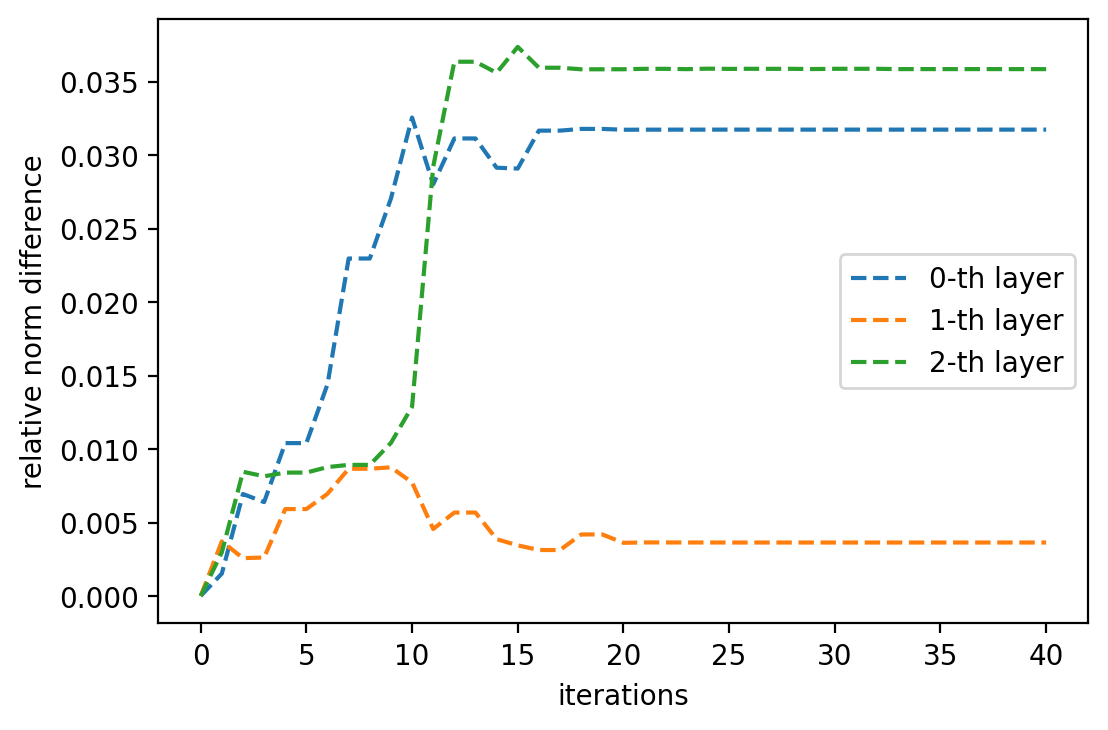

In [552]:
plt.figure(dpi=200)
plt.ylabel('relative norm difference')
plt.xlabel('iterations')
for i, diff_xi in enumerate(diff_xs):
    plt.plot(diff_xi, '--', label=f'{i}-th layer')
plt.legend()

# More layers
(12.11.23)

- see how the error changes as the number of layers increases 
    1. for the second order trotterization (odd-even-odd)
    2. For the optimized one
- change to parametrize the tangent space only using the upper diagonal of the antisymmetric matrix.

In [613]:
# local dimension, number of sites, noise strength
d, N, gamma = 2, 4, 1
# final time. Choosen this high to get a considerable error (to avoid optimizing near the numerical-zero regime)
tau = 4
from opentn.optimization import compute_kitaev_approximation_error
print(compute_kitaev_approximation_error(d, N, gamma, tau, n=6))


0.0040682753685017895


In [614]:
error_suzuki = [compute_kitaev_approximation_error(d, N, gamma, tau, n=n) for n in range(1,10)]
error_suzuki

[DeviceArray(0.14312676, dtype=float64),
 DeviceArray(0.03642549, dtype=float64),
 DeviceArray(0.01624165, dtype=float64),
 DeviceArray(0.00914625, dtype=float64),
 DeviceArray(0.00585666, dtype=float64),
 DeviceArray(0.00406828, dtype=float64),
 DeviceArray(0.00298945, dtype=float64),
 DeviceArray(0.00228905, dtype=float64),
 DeviceArray(0.00180877, dtype=float64)]

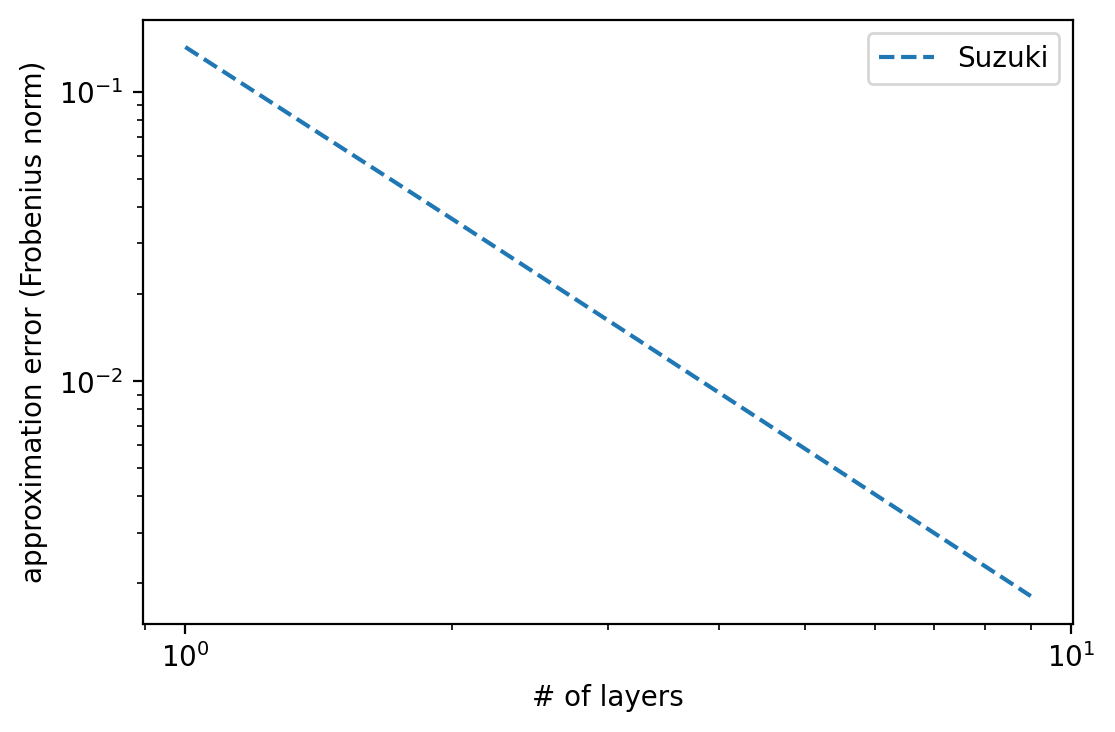

In [644]:
from opentn.utils import set_integer_labels

plt.figure(dpi=200)
plt.ylabel('approximation error (Frobenius norm)')
plt.xlabel('# of layers')
plt.loglog(range(1,10),error_suzuki, '--', label='Suzuki')
set_integer_labels()
plt.legend()

In [616]:
# let's now do it for the optimized one!
from opentn.optimization import get_kitaev_trotter_local_ansatz
# recreating this just to have them at hand
f_stiefel_layers = lambda xi: frobenius_norm(model_stiefel_local(xi, N, d, ), exp_Lvec)
grad_stiefel_layers = lambda xi: gradient_stiefel_vec(xi, f_stiefel_layers, metric='canonical')
hessian_stiefel_layers = lambda xi: riemannian_hessian_vec(xi, f_stiefel_layers, metric='canonical')

n = 2
xs_stiefel_2_layers = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=n)]
f_stiefel_layers(xs_stiefel_2_layers)

DeviceArray(0.03642549, dtype=float64)

In [617]:
xs_2_layers_1, f_2_layers_1, _, radius_2_layers_1 = riemannian_trust_region_optimize(
    f_stiefel_layers, retract_stiefel, grad_stiefel_layers, hessian_stiefel_layers, xs_stiefel_2_layers, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.04
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.04
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.01
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.02
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.02
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.005
iteration: 8
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.01
iteration: 9
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.0025
iteration: 10
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.000625
iteration: 11
column : 0
column : 1
column : 2
column : 3
column : 4
radius 0.00125
iteration: 12
column : 0
col

In [621]:
n = 3
xs_stiefel_3_layers = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=n)]
f_stiefel_layers(xs_stiefel_3_layers)

DeviceArray(0.01624165, dtype=float64)

In [622]:
xs_3_layers_1, f_3_layers_1, _, radius_3_layers_1 = riemannian_trust_region_optimize(
    f_stiefel_layers, retract_stiefel, grad_stiefel_layers, hessian_stiefel_layers, xs_stiefel_3_layers, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.04
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.01
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.02
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.02
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.005
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.005
iteration: 8
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.005
iteration: 9
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5


In [629]:
n = 3
xs_stiefel_3_layers_rank_4 = [super2ortho(x.real, rank=4) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=n)]
f_stiefel_layers(xs_stiefel_3_layers_rank_4)

DeviceArray(0.01624165, dtype=float64)

In [626]:
xs_3_layers_rank_4, f_3_layers_rank_4, _, radius_3_layers_rank_4 = riemannian_trust_region_optimize(
    f_stiefel_layers, retract_stiefel, grad_stiefel_layers, hessian_stiefel_layers, xs_stiefel_3_layers_rank_4, niter=20
)
# I FORGOT TO SAVE THE X'S!

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.04
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.01
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.02
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.02
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.005
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.005
iteration: 8
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
radius 0.005
iteration: 9
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5


In [633]:
print(ortho2choi(xs_3_layers_rank_4[0][0]))

print(ortho2choi(xs_3_layers_1[-1][0]))

print(ortho2choi(xs_3_layers_rank_4[-1][0]))

[[-1.00000000e+00  2.88871352e-16  1.31218984e-08 -4.40622040e-09]
 [ 0.00000000e+00  3.26250762e-17 -3.13920663e-11  3.36338002e-11]
 [ 0.00000000e+00  0.00000000e+00  2.29709443e-24 -1.32764306e-24]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.60022207e-01  1.95907041e-01 -8.22573683e-09 -5.63986510e-09]
 [-3.99777927e-02 -1.95907041e-01 -1.45774815e-09 -2.11197540e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.99777927e-02  1.95907041e-01  1.25129164e-09  2.80090476e-09]
 [-9.60022207e-01 -1.95907041e-01 -5.51669704e-09 -7.26984939e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e

In [634]:
n = 4
xs_stiefel_4_layers = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=n)]
f_stiefel_layers(xs_stiefel_4_layers)

DeviceArray(0.00914625, dtype=float64)

In [635]:
xs_4_layers_1, f_4_layers_1, _, radius_4_layers_1 = riemannian_trust_region_optimize(
    f_stiefel_layers, retract_stiefel, grad_stiefel_layers, hessian_stiefel_layers, xs_stiefel_4_layers, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
radius 0.01
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
radius 0.005
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
radius 0.01
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
radius 0.01
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
radius 0.0025
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
radius 0.005
iter

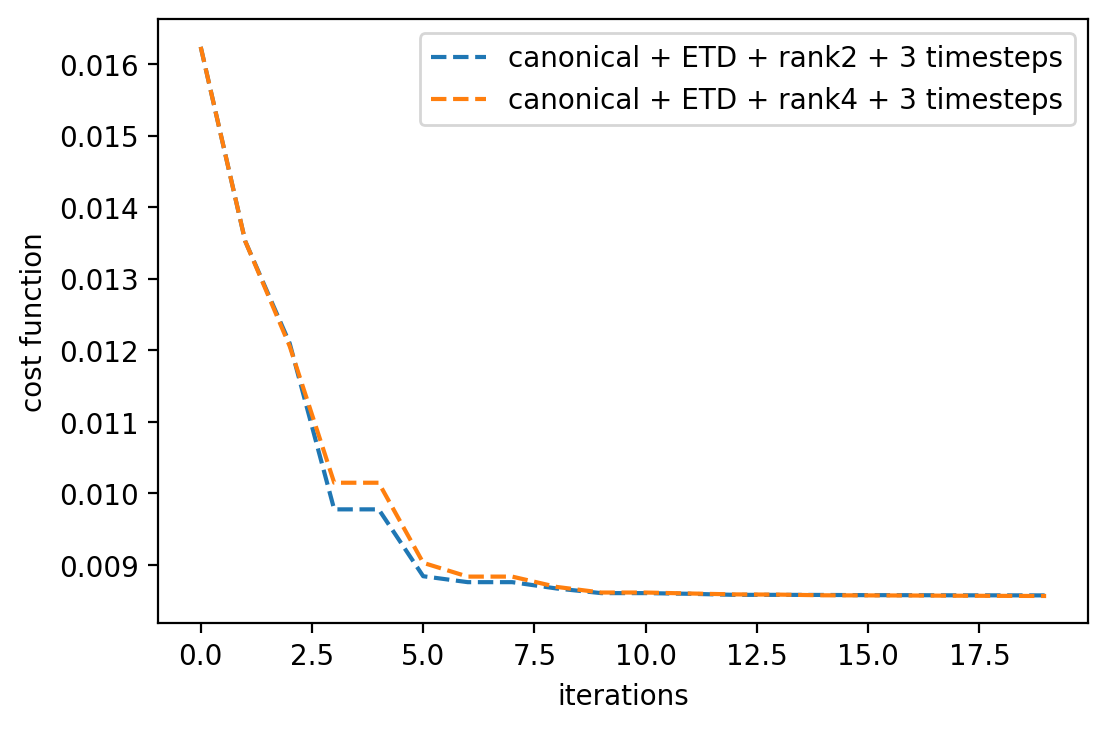

In [676]:
plt.figure(dpi=200)
plt.ylabel('cost function')
plt.xlabel('iterations')
# plt.plot(f_pbc_canon_upd_1, '--', label='canonical + ETD + rank2 + 1 timestep')
# plt.plot(f_2_layers_1, '--', label='canonical + ETD + rank2 + 2 timesteps')
plt.plot(f_3_layers_1, '--', label='canonical + ETD + rank2 + 3 timesteps')
plt.plot(f_3_layers_rank_4, '--', label='canonical + ETD + rank4 + 3 timesteps')
# plt.plot(f_4_layers_1, '--', label='canonical + ETD + rank2 + 4 timesteps')
plt.legend()

In [677]:
print(f_3_layers_1)
print(f_3_layers_rank_4)

[DeviceArray(0.01624165, dtype=float64), DeviceArray(0.01352733, dtype=float64), DeviceArray(0.012099, dtype=float64), DeviceArray(0.00977832, dtype=float64), DeviceArray(0.00977832, dtype=float64), DeviceArray(0.00884378, dtype=float64), DeviceArray(0.00876087, dtype=float64), DeviceArray(0.00876087, dtype=float64), DeviceArray(0.00867221, dtype=float64), DeviceArray(0.00860772, dtype=float64), DeviceArray(0.00860772, dtype=float64), DeviceArray(0.00859807, dtype=float64), DeviceArray(0.00858344, dtype=float64), DeviceArray(0.00858344, dtype=float64), DeviceArray(0.0085822, dtype=float64), DeviceArray(0.00857936, dtype=float64), DeviceArray(0.00857887, dtype=float64), DeviceArray(0.00857699, dtype=float64), DeviceArray(0.00857663, dtype=float64), DeviceArray(0.008576, dtype=float64)]
[DeviceArray(0.01624165, dtype=float64), DeviceArray(0.01352743, dtype=float64), DeviceArray(0.01205813, dtype=float64), DeviceArray(0.01015049, dtype=float64), DeviceArray(0.01015049, dtype=float64), Dev

In [675]:
for i in ([values[-1]/values[0] for values in [f_pbc_canon_upd_1, f_2_layers_1, f_3_layers_1, f_4_layers_1]]):
    print(i)

0.8839147329654644
0.5704209114571059
0.5280250032817817
0.5131551269733742


In [651]:
# compare the un-optimized with the optimized:
error_stiefel = [values[-1] for values in [f_pbc_canon_upd_1, f_2_layers_1, f_3_layers_1, f_4_layers_1]]

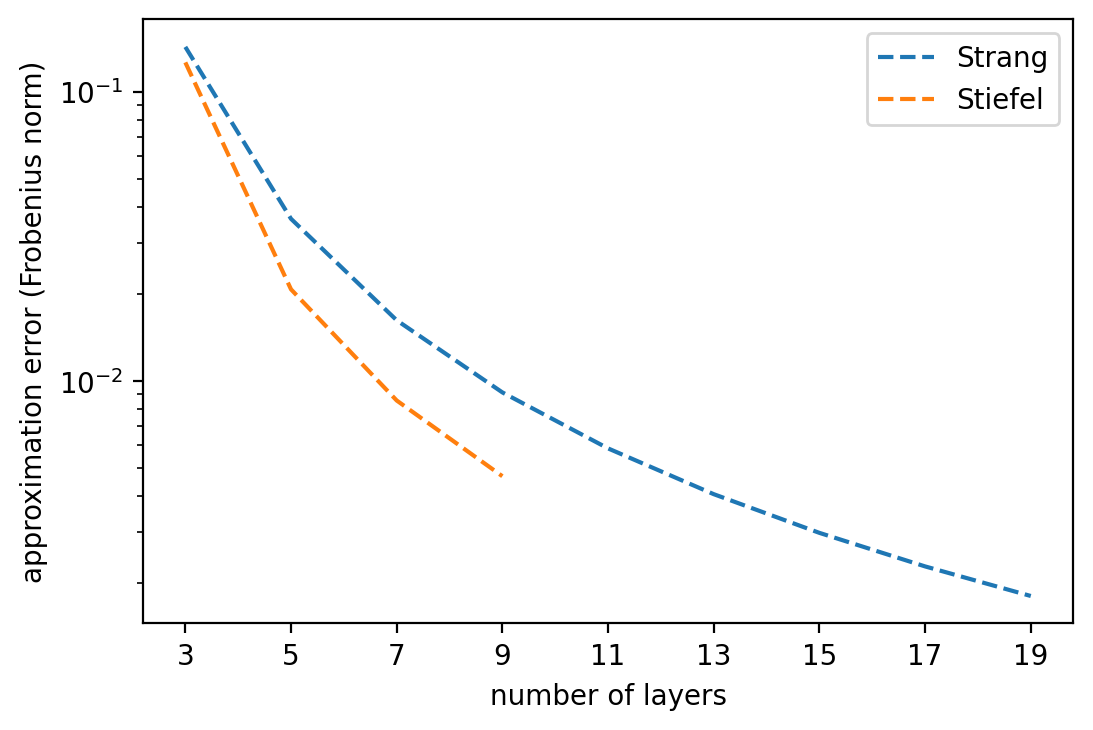

In [672]:
from opentn.utils import set_discrete_labels
fig = plt.figure(dpi=200)
ax = plt.gca()
plt.ylabel('approximation error (Frobenius norm)')
plt.xlabel('number of layers')
plt.semilogy(error_suzuki, '--', label='Strang') #or Suzuki?
plt.semilogy(error_stiefel, '--', label='Stiefel')
set_discrete_labels(labels=[str(index) for index in (2*np.arange(1,len(error_suzuki)+1) + 1)], ax=ax, rotation=0)
plt.legend()

# Fixing the parametrization:

In [707]:
x = xs_pbc_stiefel[0]
p = x.shape[1]
a = np.array(list(range(p**2))).reshape(p,p)
from opentn.stiefel import square_to_upper_triangular, upper_triangular_to_antisymmetric, is_antisymmetric
a_anti = upper_triangular_to_antisymmetric(square_to_upper_triangular(a), a.shape[0])
a_anti, is_antisymmetric(a_anti)

(array([[  0.,   1.,   2.,   3.],
        [ -1.,   0.,   6.,   7.],
        [ -2.,  -6.,   0.,  11.],
        [ -3.,  -7., -11.,   0.]]),
 True)

In [753]:
upper = a[np.triu_indices_from(a, k=1)]
print(upper)
stacked = np.hstack([upper, a.reshape(-1)])
stacked, stacked.shape

[ 1  2  3  6  7 11]


(array([ 1,  2,  3,  6,  7, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14, 15]),
 (22,))

In [765]:
a.shape, a.size

((4, 4), 16)

In [762]:
n = 3
all_stacked = np.hstack([i*stacked for i in range(1,n+1)])
all_stacked.shape, all_stacked, np.hsplit(all_stacked, n)[2]

((66,),
 array([ 1,  2,  3,  6,  7, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14, 15,  2,  4,  6, 12, 14, 22,  0,  2,  4,  6,  8, 10,
        12, 14, 16, 18, 20, 22, 24, 26, 28, 30,  3,  6,  9, 18, 21, 33,  0,
         3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45]),
 array([ 3,  6,  9, 18, 21, 33,  0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30,
        33, 36, 39, 42, 45]))

In [746]:
np.allclose(np.vstack([a,a]).reshape(-1), np.hstack([a.reshape(-1), a.reshape(-1)]))

True

In [730]:
upper.shape, a.reshape(-1).shape, upper[:, None].T.shape, a.reshape(-1)[:,None].T.shape

((6,), (16,), (1, 6), (1, 16))

In [716]:
canonical_metric(delta1=x@(Eij-Eji), delta2=x@(Eij-Eji), x=x), canonical_metric(delta1=x@Eij, delta2=x@Eij, x=x)

(0.9999999999999999, 0.5)

In [717]:
canonical_metric(delta1=x@(a_anti), delta2=x@(a_anti), x=x), canonical_metric(delta1=x@a, delta2=x@a, x=x)

(220.0, 620.0)

In [719]:
from opentn.stiefel import euclidean_metric
euclidean_metric(delta1=x@(Eij-Eji), delta2=x@(Eij-Eji))

2.0000000000000004

In [771]:
# after all these changes I don't expet it to work at once, but let's see:
f_stiefel_param = lambda xi: frobenius_norm(model_stiefel_local(xi, N, d, ), exp_Lvec)
grad_stiefel_param = lambda xi: gradient_stiefel_vec(xi, f_stiefel_param, metric='canonical')
hessian_stiefel_param = lambda xi: riemannian_hessian_vec(xi, f_stiefel_param, metric='canonical')

xs_param, f_param, err_param, radius_param = riemannian_trust_region_optimize(
    f_stiefel_param, retract_stiefel, grad_stiefel_param, hessian_stiefel_param, xs_pbc_stiefel, save_x=True, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.02
iteration: 4
column : 0
column : 1
column : 2
radius 0.02
iteration: 5
column : 0
column : 1
column : 2
radius 0.02
iteration: 6
column : 0
column : 1
column : 2
radius 0.02
iteration: 7
column : 0
column : 1
column : 2
radius 0.02
iteration: 8
column : 0
column : 1
column : 2
radius 0.02
iteration: 9
column : 0
column : 1
column : 2
radius 0.005
iteration: 10
column : 0
column : 1
column : 2
radius 0.00125
iteration: 11
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 12
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 13
column : 0
column : 1
column : 2
radius 1.953125e-05
iteration: 14
column : 0
column : 1
column : 2
radius 4.8828125e-06
iteration: 15
column : 0
column : 1
column : 2
radius 1.220703125e-06
iteration: 16
column : 

In [774]:

xs_param_rank4, f_param_rank4, err_param_rank4, radius_param_rank4 = riemannian_trust_region_optimize(
    f_stiefel_param, retract_stiefel, grad_stiefel_param, hessian_stiefel_param, xs_stiefel_rank4, save_x=True, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.04
iteration: 4
column : 0
column : 1
column : 2
radius 0.01
iteration: 5
column : 0
column : 1
column : 2
radius 0.02
iteration: 6
column : 0
column : 1
column : 2
radius 0.04
iteration: 7
column : 0
column : 1
column : 2
radius 0.04
iteration: 8
column : 0
column : 1
column : 2
radius 0.08
iteration: 9
column : 0
column : 1
column : 2
radius 0.02
iteration: 10
column : 0
column : 1
column : 2
radius 0.04
iteration: 11
column : 0
column : 1
column : 2
radius 0.04
iteration: 12
column : 0
column : 1
column : 2
radius 0.01
iteration: 13
column : 0
column : 1
column : 2
radius 0.02
iteration: 14
column : 0
column : 1
column : 2
radius 0.02
iteration: 15
column : 0
column : 1
column : 2
radius 0.005
iteration: 16
column : 0
column : 1
column : 2
radius 0.00125
ite

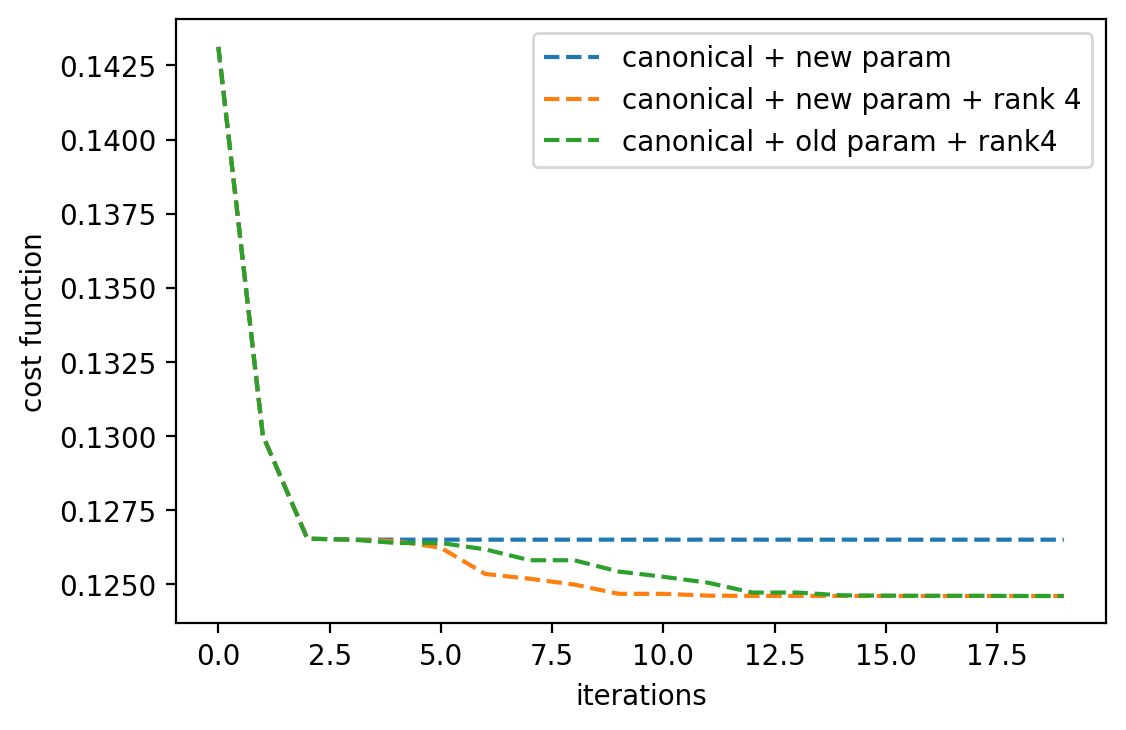

In [777]:
plt.figure(dpi=200)
plt.ylabel('cost function')
plt.xlabel('iterations')
plt.plot(f_param, '--', label='canonical + new param')
plt.plot(f_param_rank4, '--', label='canonical + new param + rank 4')
plt.plot(f_canon_rank4_1[:20], '--', label='canonical + old param + rank4')
plt.legend()